## Imports and Loading

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import sklearn
import missingno as msno
import fancyimpute

In [24]:
X_train = pd.read_csv("../dengue_features_train.csv")
y_train = pd.read_csv("../dengue_labels_train.csv")
X_test = pd.read_csv("../dengue_features_test.csv")

# Quick Date Feature Engineering
city_map = {"sj":0, "iq":1}

X_train["city"].replace(city_map, inplace = True)

X_train['month'] = pd.DatetimeIndex(X_train['week_start_date']).month
# X_train['day'] = pd.DatetimeIndex(X_train['week_start_date']).day

X_test["city"].replace(city_map, inplace = True)
X_test['month'] = pd.DatetimeIndex(X_test['week_start_date']).month
# X_test['day'] = pd.DatetimeIndex(X_test['week_start_date']).day

# Create separate df's for different cities to prevent 'concept drift'
X_sj = X_train[X_train.city == 0].drop(["week_start_date"], axis = 1)
X_iq = X_train[X_train.city == 1].drop(["week_start_date"], axis = 1)

# And for the test set
X_test_sj = X_test[X_test.city == 0].drop(["week_start_date"], axis = 1)
X_test_iq = X_test[X_test.city == 1].drop(["week_start_date"], axis = 1)

submission_format = pd.read_csv("../submission_format.csv")

## Quick Look

In [3]:
X_sj.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
0,0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,0,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,0,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,5
3,0,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,5
4,0,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,5


In [25]:
X_iq.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,month
936,1,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,7
937,1,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,7
938,1,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,7
939,1,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,7
940,1,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,7


## Sums of Missing Values

In [26]:
X_train.isna().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [5]:
X_test.isna().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

## Is there a dependence among missing variables?

Let's do some tests to see if the data is missing at random or missing not at random

A reminder:

* MCAR - no clear pattern to missingness.
* MAR - There might exist some correlation and meaning between missing values and other variables.
* MNAR - There IS a relationship between missingness and its values.

Reference: https://libraries.io/pypi/missingno

<AxesSubplot:>

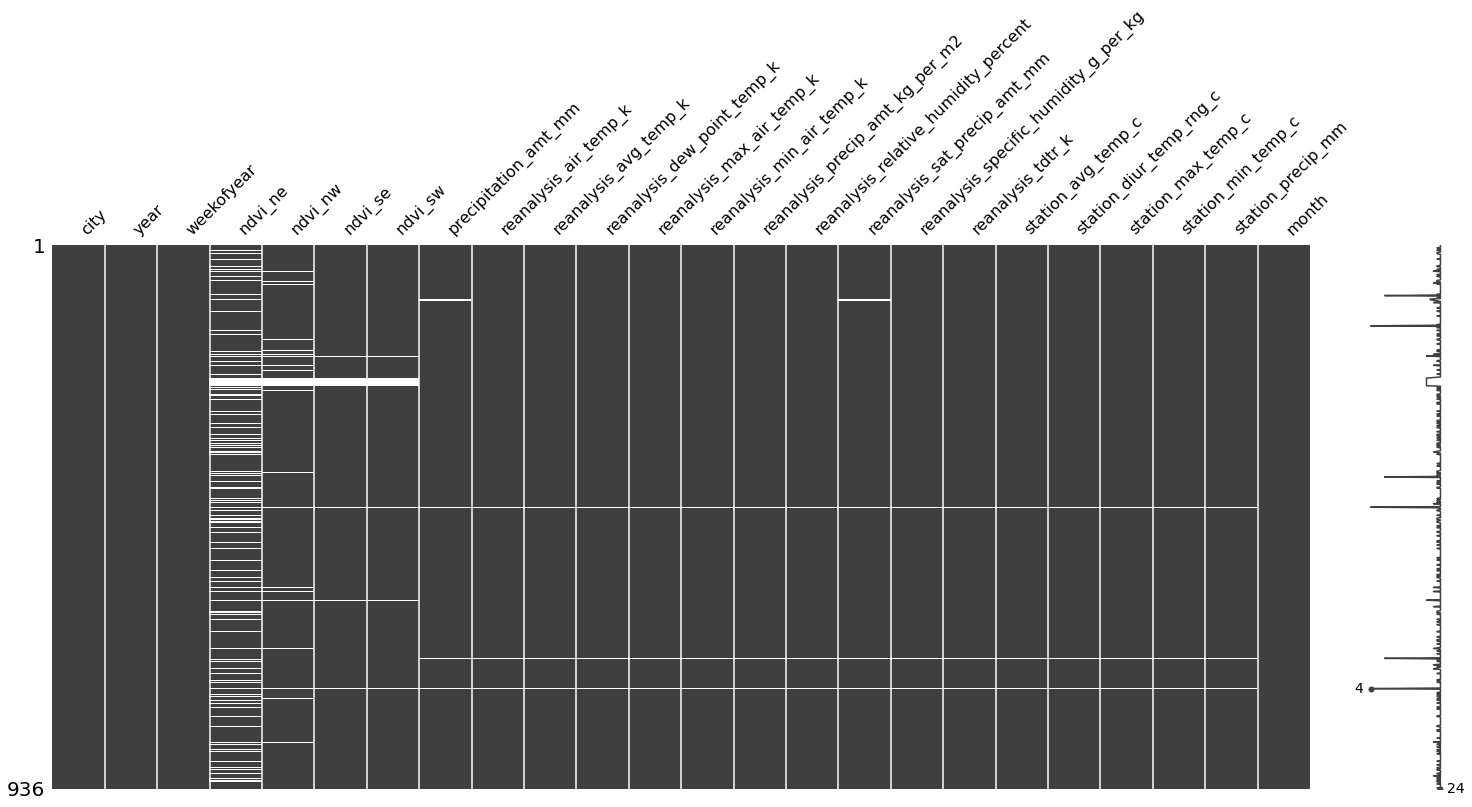

In [6]:
msno.matrix(X_sj)

<AxesSubplot:>

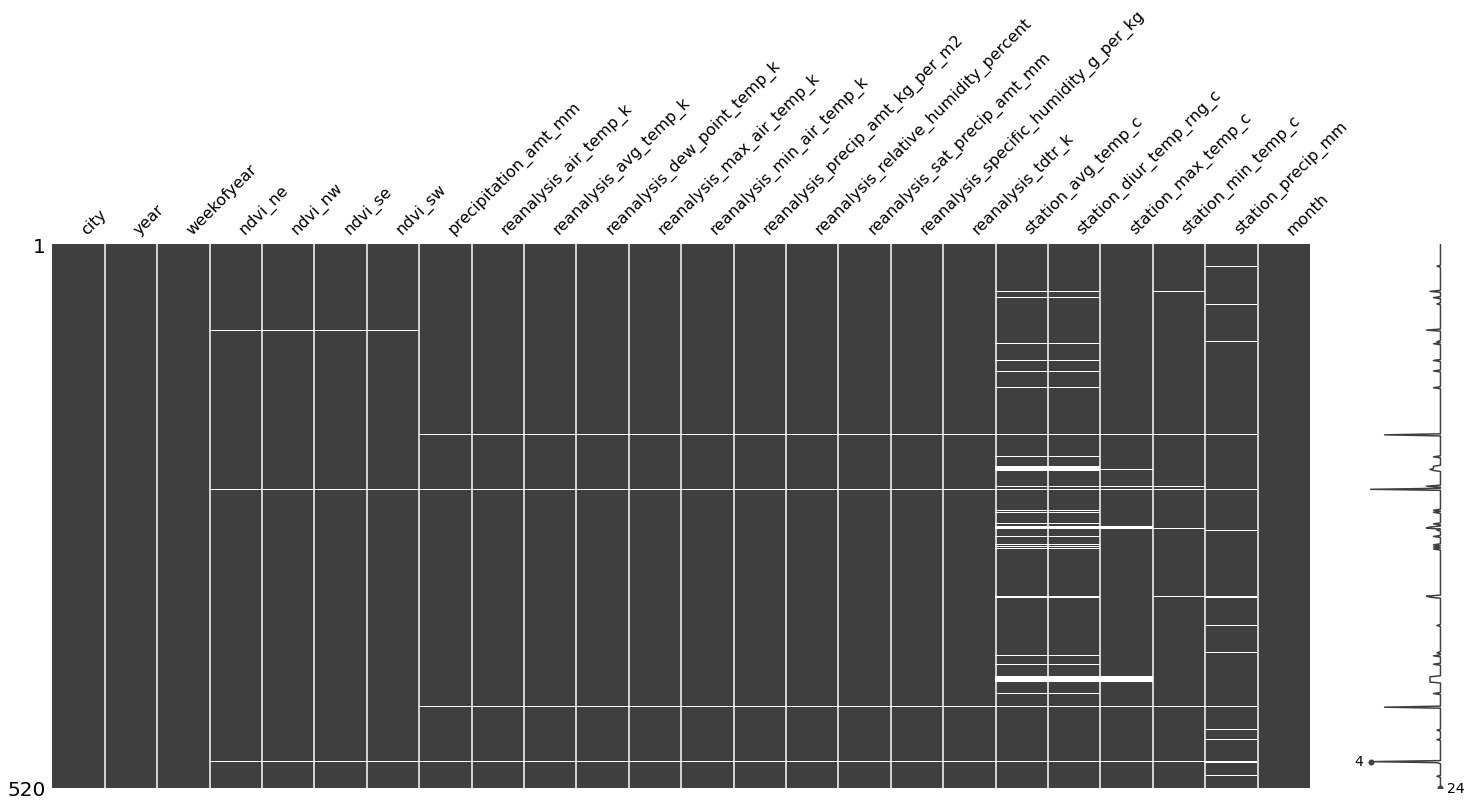

In [7]:
msno.matrix(X_iq)

### Insights

* It looks like some days have missing data across the board, while others are missing data in just two columns.  We will investigate these rows to see if they have any interesting features.  We can do this by grouping by whether a column is missing or not and seeing if this has any significance to other variables, especially the target variable.


## Groupby Analysis

<AxesSubplot:>

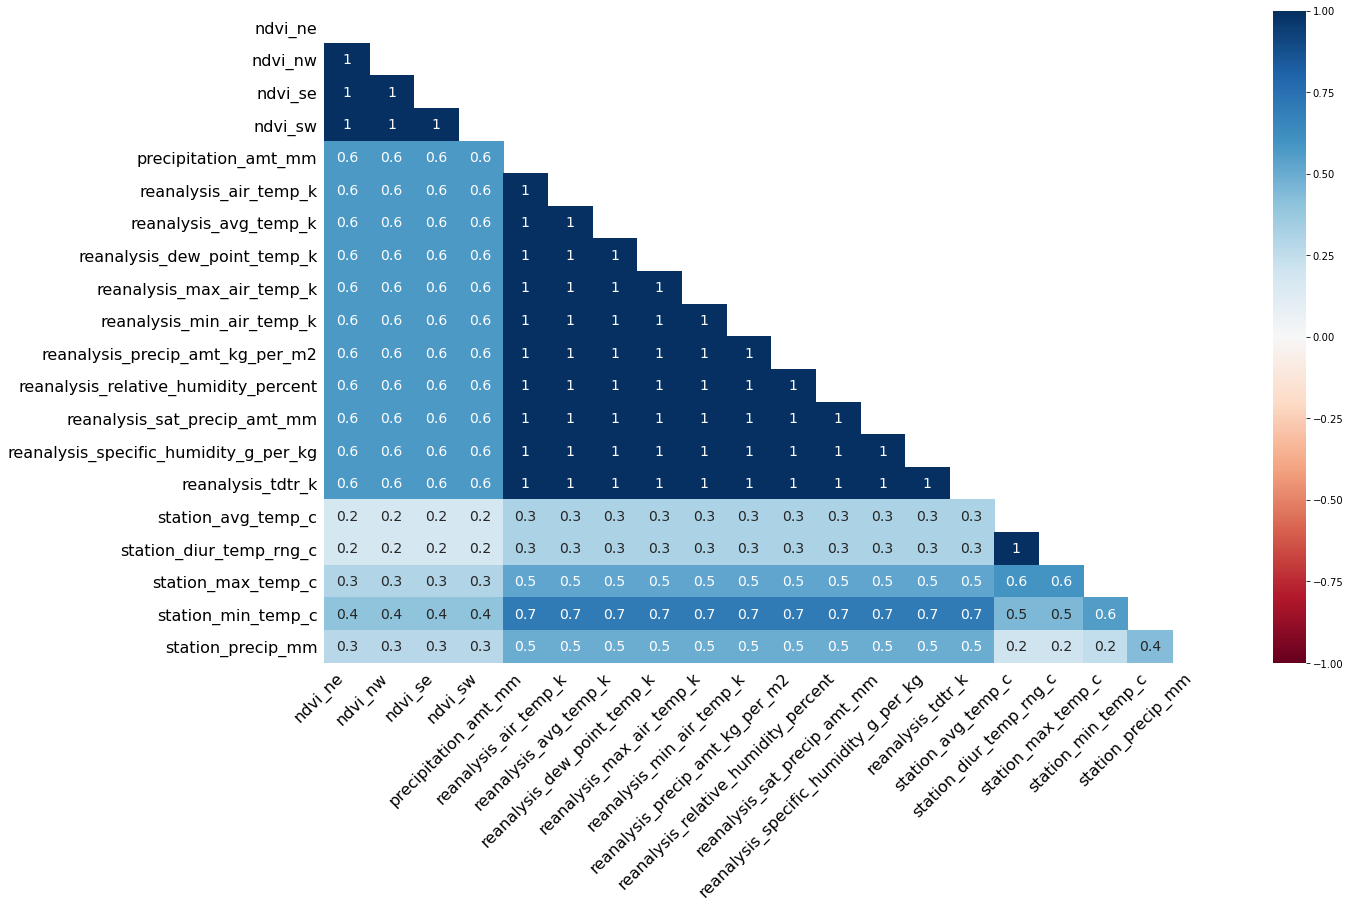

In [8]:
# Nullity Correlation.  How much the absence or presence of one variable effects 
# The presence or absence of another

msno.heatmap(X_iq)  

<AxesSubplot:>

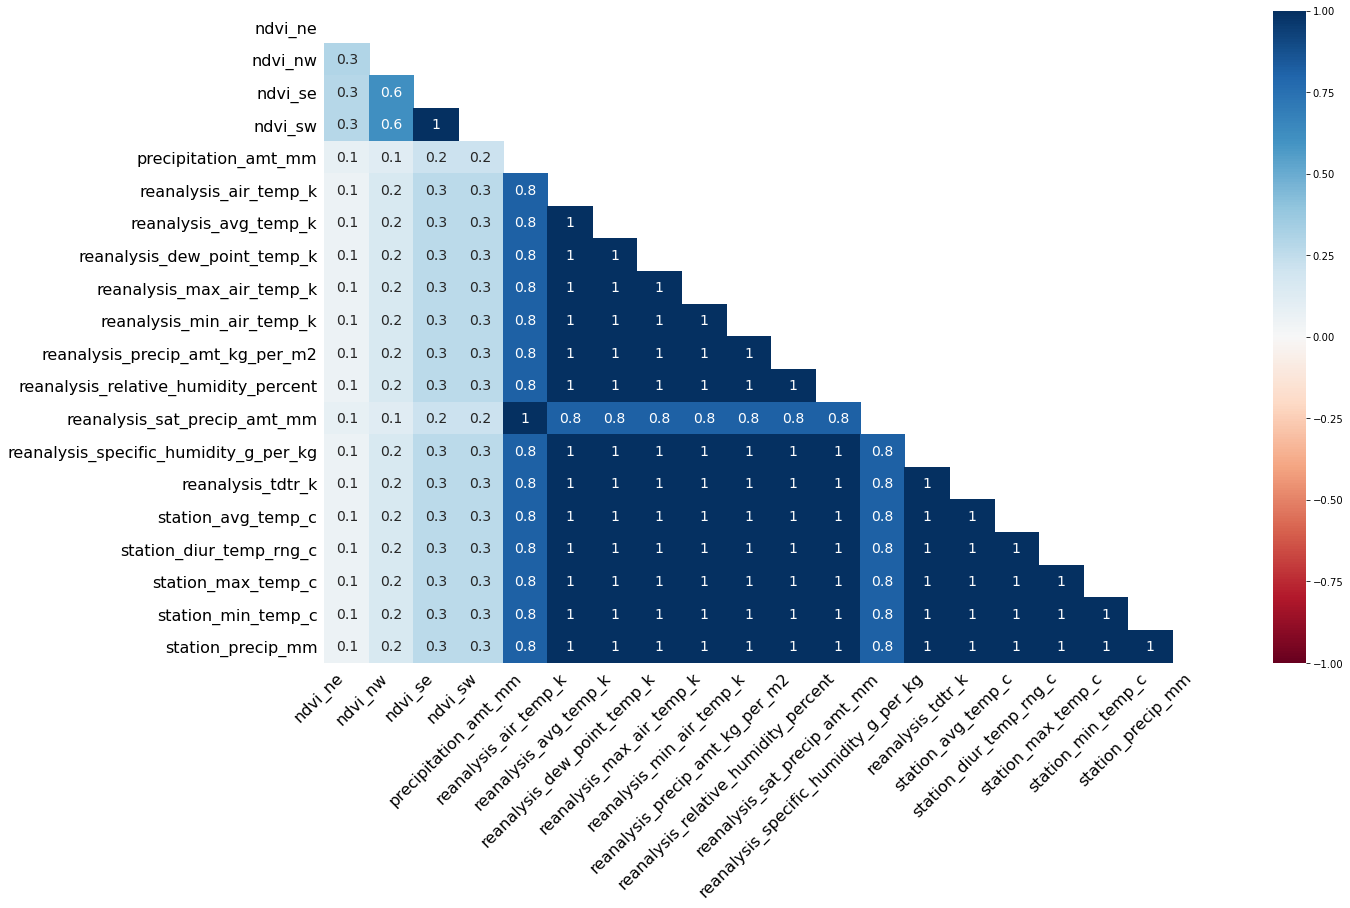

In [9]:
msno.heatmap(X_sj)

<AxesSubplot:>

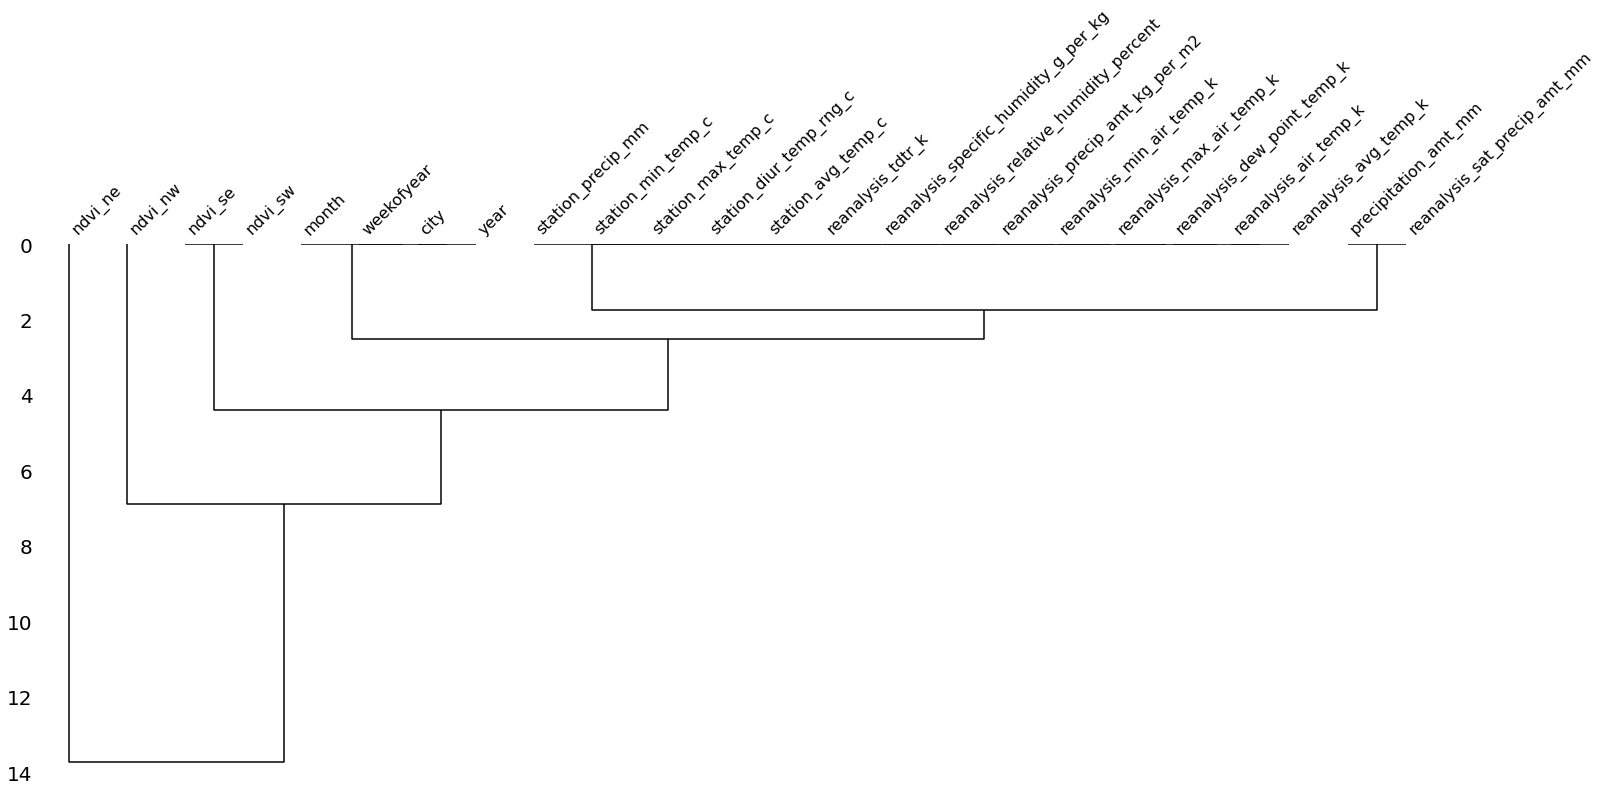

In [10]:
msno.dendrogram(X_sj)

<AxesSubplot:>

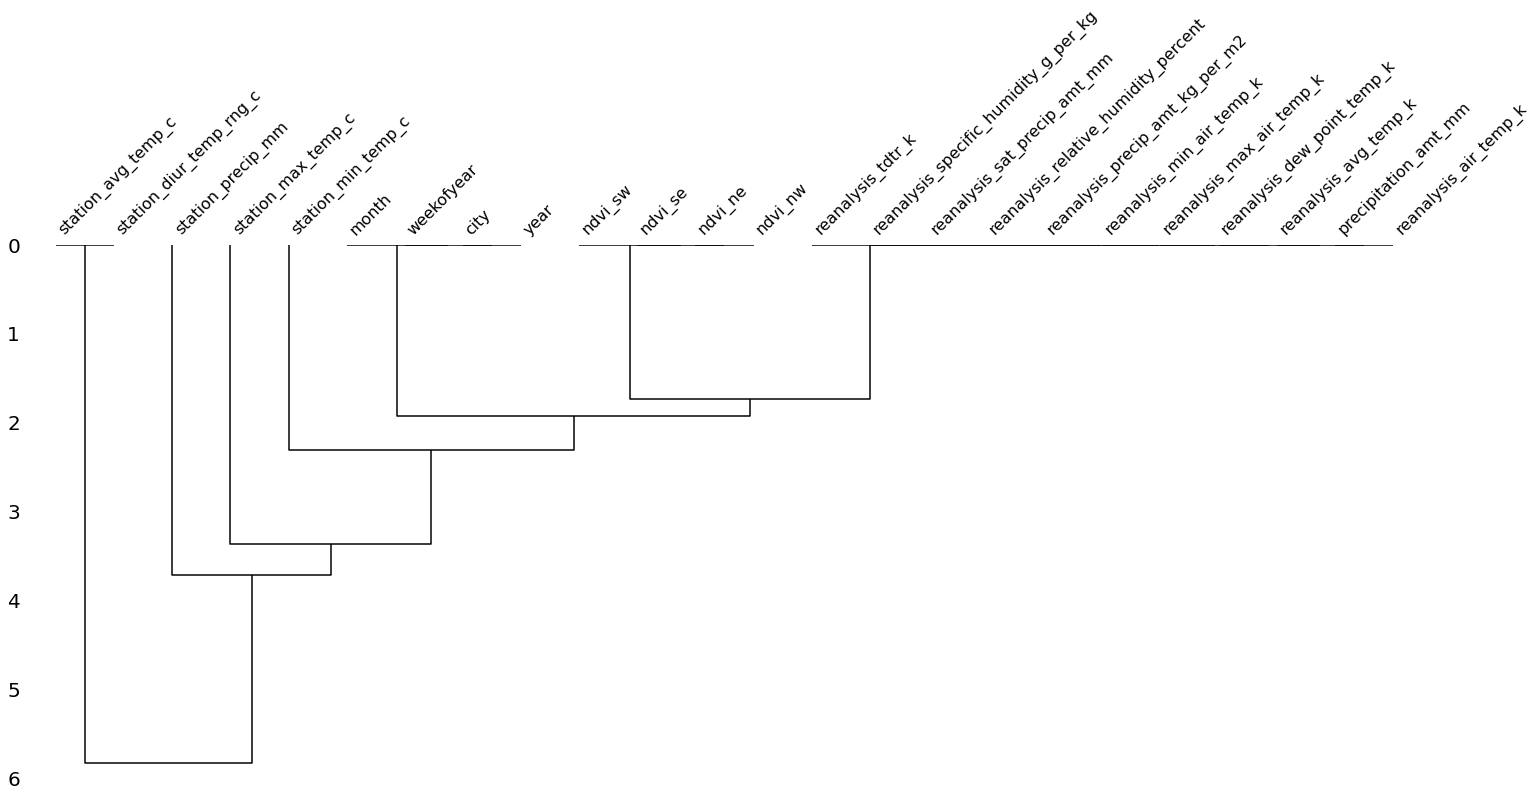

In [11]:
msno.dendrogram(X_iq)

## Helper function

In [12]:
export_path = "../deng_features/"

def impute_df(df, export_name = None, method = None, verbose = True, export = True):
    df_cols = df.columns
    
    if method == "iterative":
        df_filled = fancyimpute.IterativeImputer().fit_transform(df)
        df_filled = pd.DataFrame(df_filled, columns = df_cols)
    
    if method == "interpolate":
        df_filled = df.interpolate()
    
    if verbose:
        print("Original DF has missing values:", df.isna().sum().any())
        print("Imputed DF has Missing Values: ", df_filled.isna().sum().any())
    
    if export:
        df_filled.to_csv(export_path + export_name + ".csv")
        
        if verbose:
            print("csv exported to: ", export_path + export_name)
    
    return df_filled

In [13]:
def label_missing_cols(df, export_name = None, export = True):
    """
    Creates a new feature for each row colname_is_missing
    if it has a missing value at that column
    
    to do: create a threshold
    """
    
    export_path
    
    df_cols = df.columns
    
    missing_labels = df.isna()
    
    missing_labels = missing_labels.add_suffix('_is_missing')
    
    if export:
        missing_labels.to_csv(export_path + export_name + ".csv")
    
    return missing_labels
    

## Label Missing Columns in X_train and X_test

In [14]:
X_train_miss_labelled = label_missing_cols(X_train,
                                     export_name = "X_train_is_missing")
X_train_miss_labelled

,city_is_missing,year_is_missing,weekofyear_is_missing,week_start_date_is_missing,ndvi_ne_is_missing,ndvi_nw_is_missing,ndvi_se_is_missing,ndvi_sw_is_missing,precipitation_amt_mm_is_missing,reanalysis_air_temp_k_is_missing,...,reanalysis_relative_humidity_percent_is_missing,reanalysis_sat_precip_amt_mm_is_missing,reanalysis_specific_humidity_g_per_kg_is_missing,reanalysis_tdtr_k_is_missing,station_avg_temp_c_is_missing,station_diur_temp_rng_c_is_missing,station_max_temp_c_is_missing,station_min_temp_c_is_missing,station_precip_mm_is_missing,month_is_missing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1454,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
X_test_miss_labelled = label_missing_cols(X_test,
                                     export_name = "X_test_is_missing")
X_test_miss_labelled

,city_is_missing,year_is_missing,weekofyear_is_missing,week_start_date_is_missing,ndvi_ne_is_missing,ndvi_nw_is_missing,ndvi_se_is_missing,ndvi_sw_is_missing,precipitation_amt_mm_is_missing,reanalysis_air_temp_k_is_missing,...,reanalysis_relative_humidity_percent_is_missing,reanalysis_sat_precip_amt_mm_is_missing,reanalysis_specific_humidity_g_per_kg_is_missing,reanalysis_tdtr_k_is_missing,station_avg_temp_c_is_missing,station_diur_temp_rng_c_is_missing,station_max_temp_c_is_missing,station_min_temp_c_is_missing,station_precip_mm_is_missing,month_is_missing
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
412,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
413,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Iterative Imputation

This may be useful for the MCAR column of ndvi_ne

It may also be useful for the first rows of the data.

In [16]:
X_sj_filled_ii = impute_df(X_sj, 
                          export_name = "X_sj_filled_ii",
                          method = "iterative")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_sj_filled_ii


In [17]:
X_iq_filled_ii = impute_df(X_iq, 
                          export_name = "X_iq_filled_ii",
                          method = "iterative")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_iq_filled_ii


In [18]:
X_test_sj_filled_ii = impute_df(X_test_sj, 
                          export_name = "X_test_sj_filled_ii",
                          method = "iterative")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_test_sj_filled_ii


In [19]:
X_test_iq_filled_ii = impute_df(X_test_iq, 
                          export_name = "X_test_iq_filled_ii",
                          method = "iterative")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_test_iq_filled_ii


## Interpolated Imputation

This may be useful for if there is a missing value here or there, not where there are long strings of missing values in a row.

In [20]:
X_sj_filled_interp = impute_df(X_sj, 
                          export_name = "X_sj_filled_interp",
                          method = "interpolate")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_sj_filled_interp


In [21]:
X_iq_filled_interp = impute_df(X_iq, 
                          export_name = "X_iq_filled_interp",
                          method = "interpolate")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_iq_filled_interp


In [22]:
X_test_sj_filled_interp = impute_df(X_test_sj, 
                          export_name = "X_test_sj_filled_interp",
                          method = "interpolate")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_test_sj_filled_interp


In [23]:
X_test_iq_filled_interp = impute_df(X_test_iq, 
                          export_name = "X_test_iq_filled_interp",
                          method = "interpolate")

Original DF has missing values: True
Imputed DF has Missing Values:  False
csv exported to:  ../deng_features/X_test_iq_filled_interp
